# A Boolean network model of gene regulation in the bacterial _lac_ operon
## Kian Faizi, Math 111A Final Project, Fall 2020

My goal is to build off of work described in Veliz-Cuba et al., "Boolean Models Can Explain Bistability in the _lac_ Operon", Journal of Computational Biology (2011).

Endogenous variables:
- lactose, in and out of cell
- glucose, in and out of cell
- lac RNA
- allolactose, inactivates lacI
- cAMP, synthesis inhibited at high glucose levels
- CAP, complexes with cAMP and binds DNA to enhance transcription
- beta-galactosidase (lacZ), cleaves lactose into glucose and galactose, and converts lactose into allolactose
- beta-galactoside permease (lacY), imports extracellular lactose, in and out of membrane (?)
- lacI, repressor that binds operator

Boolean Functions from the paper, excluding the 'medium' concentration distinction:
lac mRNA: CAP AND NOT LacI
lacY, lacZ: lac mRNA
CAP: NOT glucose (in or out of the cell? check the mechanism for CAP formation) !!
lacI: NOT allolactose
allolactose in the cell: lacZ AND lactose in the cell
lactose in the cell: lacY AND lactose outside the cell AND NOT glucose outside the cell (? check mechanism for glucose. some import can happen by diffusion, right?)

My formulations:
Lactose: extracellular lactose AND lacY in membrane AND NOT extracellular glucose
lac mRNA: CAP-cAMP AND NOT lacI
cAMP-CAP: CAP AND cAMP
cAMP: NOT glucose (in the cell?)
lacZ, lacY: lac mRNA
lacI: NOT allolactose
allolactose: intracellular lactose AND lacZ

Assumptions: cap is constitutively expressed (always True)
extracellular glucose is always imported into the cell (so gluc = gluc ext OR (lacz and lac))


In [128]:
import boolean2 as b2
import pylab
from boolean2 import util, state, network
import networkx as nx
import matplotlib.pyplot as plt

In [304]:
text = """
# initial values
cap = True
lac_ext = Random
gluc_ext = Random
lac = Random
allolac = Random
camp_cap = Random
camp = Random
lacy = Random
laci = Random
rna = Random

# updating rules
lac* = (lac_ext and lacy) or (lac_ext and not gluc_ext)
allolac* = lac
camp_cap* = camp and cap
camp* = not gluc_ext
lacy* = rna
laci* = not allolac
rna* = camp_cap and not laci
"""

(-1.1748115542531012,
 1.182133883535862,
 -0.5969454362988472,
 0.5969454392790795)

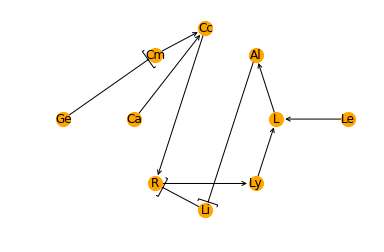

In [305]:
model = b2.Model(text=text, mode='sync')
model.initialize()

DG = nx.DiGraph()
DG.add_nodes_from(model.nodes)
DG.add_edges_from([
    ('lac_ext','lac',{'weight':1}),
    ('lacy','lac',{'weight':1}),
    ('lac','allolac',{'weight':1}),
    ('camp','camp_cap',{'weight':1}),
    ('cap','camp_cap',{'weight':1}),
    ('gluc_ext','camp',{'weight':-1}),
    ('rna','lacy',{'weight':1}),
    ('allolac','laci',{'weight':-1}),
    ('camp_cap','rna',{'weight':1}),
    ('laci','rna',{'weight':-1})
])

shells = [
    ['lac','allolac','camp_cap','camp','cap','rna','laci','lacy'],
    ['lac_ext','gluc_ext'] # outer last
]


epos=[(u,v) for (u,v,d) in DG.edges(data=True) if d['weight']==1]
eneg=[(u,v) for (u,v,d) in DG.edges(data=True) if d['weight']==-1]
pos = nx.shell_layout(DG, nlist=shells)
nx.draw_networkx_nodes(DG, pos, node_size=200,with_labels=True,node_color='orange')
nx.draw_networkx_edges(DG,pos,edgelist=epos,arrowstyle='->')
nx.draw_networkx_edges(DG,pos,edgelist=eneg,arrowstyle='-[')

label_abbrev = {
    'lac_ext' : 'Le',
    'cap' : 'Ca',
    'gluc_ext' : 'Ge',
    'lac' : 'L',
    'allolac' : 'Al',
    'camp_cap' : 'Cc',
    'camp' : 'Cm',
    'lacy' : 'Ly',
    'laci' : 'Li',
    'rna' : 'R',
}
nx.draw_networkx_labels(DG,pos,labels=label_abbrev)
plt.axis('off')
#plt.savefig('wiring.png')  

In [309]:
def part_simulator():
    """Just simulate some states."""
    global text
    # nodes to overexpress (set True)
    ox = ['camp']
    # nodes to knockout (set to false, updating rule removed)
    ko = ['laci']
    # do it
    text = b2.modify_states(text, turnon=ox, turnoff=ko)
    seen = {}
    for i in range(512):
        model = b2.Model(text=text, mode='sync')
        model.initialize()
        model.iterate(10)
        key = model.first.fp()
        if key in (29,344,366,80):
            print(key)
            print(model.first)
        size, _ = model.detect_cycles()
        values = [ x.fp() for x in model.states]
        seen[key] = (size, values)
    return seen

seen = part_simulator()

344
State: allolac=True, camp=True, camp_cap=True, cap=True, gluc_ext=True, lac=True, lac_ext=True, laci=False, lacy=True, rna=True
29
State: allolac=True, camp=True, camp_cap=True, cap=True, gluc_ext=False, lac=True, lac_ext=True, laci=False, lacy=True, rna=True
29
State: allolac=True, camp=True, camp_cap=True, cap=True, gluc_ext=False, lac=True, lac_ext=True, laci=False, lacy=True, rna=True
366
State: allolac=False, camp=True, camp_cap=True, cap=True, gluc_ext=True, lac=False, lac_ext=False, laci=False, lacy=True, rna=True
80
State: allolac=False, camp=True, camp_cap=True, cap=True, gluc_ext=False, lac=False, lac_ext=False, laci=False, lacy=True, rna=True
366
State: allolac=False, camp=True, camp_cap=True, cap=True, gluc_ext=True, lac=False, lac_ext=False, laci=False, lacy=True, rna=True
366
State: allolac=False, camp=True, camp_cap=True, cap=True, gluc_ext=True, lac=False, lac_ext=False, laci=False, lacy=True, rna=True
344
State: allolac=True, camp=True, camp_cap=True, cap=True, glu

In [279]:
def full_simulator(initializer): 
    """Try to simulate all possible starting states..."""
    initializer = state.all_initial_states(model.nodes, limit=None)
    seen = {}
    for data, initfunc in initializer:
        model.initialize(missing=initfunc)
        key = model.first.fp()
        model.iterate(10)
        size, _ = model.detect_cycles()
        values = [ x.fp() for x in model.states]
        seen[key] = (size, values)
    return seen

seen = full_simulator(initializer)

55
State: allolac=False, camp=False, camp_cap=False, cap=True, gluc_ext=True, lac=False, lac_ext=False, laci=True, lacy=False, rna=False
29
State: allolac=True, camp=True, camp_cap=True, cap=True, gluc_ext=False, lac=True, lac_ext=True, laci=False, lacy=True, rna=True
29
State: allolac=True, camp=True, camp_cap=True, cap=True, gluc_ext=False, lac=True, lac_ext=True, laci=False, lacy=True, rna=True
21
State: allolac=True, camp=False, camp_cap=False, cap=True, gluc_ext=True, lac=True, lac_ext=True, laci=False, lacy=False, rna=False
21
State: allolac=True, camp=False, camp_cap=False, cap=True, gluc_ext=True, lac=True, lac_ext=True, laci=False, lacy=False, rna=False
41
State: allolac=False, camp=True, camp_cap=True, cap=True, gluc_ext=False, lac=False, lac_ext=False, laci=True, lacy=False, rna=False
41
State: allolac=False, camp=True, camp_cap=True, cap=True, gluc_ext=False, lac=False, lac_ext=False, laci=True, lacy=False, rna=False


In [308]:
# length of the cycle, and index at which the cycle began. Index is always 1 here.
# no cycle longer than 7, so we can reduce the iterations to ~10
# but, if there are multiple distinct cycles of same length and index, we will miss them here.
attractors = set()
for first, values in list(seen.items()):
    print('Start: %s -> %s' % (first, values))
    attractors.add(values[-1][-1])
print(attractors)

Start: 518 -> (2, [518, 33, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 520 -> (5, [520, 482, 527, 231, 261, 344, 344, 344, 344, 344, 344])
Start: 522 -> (2, [522, 261, 344, 344, 344, 344, 344, 344, 344, 344, 344])
Start: 527 -> (3, [527, 231, 261, 344, 344, 344, 344, 344, 344, 344, 344])
Start: 529 -> (3, [529, 104, 28, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 26 -> (3, [26, 27, 28, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 27 -> (2, [27, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 28 -> (1, [28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 29 -> (0, [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 32 -> (2, [32, 33, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 33 -> (1, [33, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 35 -> (2, [35, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 43 -> (3, [43, 27, 28, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 44 -> (3, [44, 38, 88, 80, 80, 80, 80, 80, 80, 80, 80])
Start: 45 -> (2, [45, 46, 29, 29, 29, 29, 29, 29, 29, 29, 29])
Start: 46 -> (

/home/kian/.conda/envs/py2/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f0275c603d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


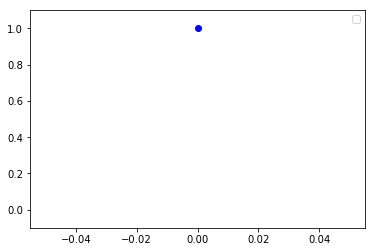

In [284]:
#plot results
p1 = pylab.plot( model.data["rna"] , 'ob-' )
pylab.legend( [p1], ["rna"])
pylab.ylim((-0.1,1.1))
pylab.show()   